<a href="https://colab.research.google.com/github/ko-redtruck/facial-landmark-detection/blob/main/ResNet18_colab_ImageTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
EPOCHS = 200
BATCH_SIZE = 400
LR = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.01
DATASET_AUGMENTATION_FACTOR = 2

In [2]:
!pip install wandb -qU
import wandb

wandb.login()

wandb: Currently logged in as: leonardhorns. Use `wandb login --relogin` to force relogin


True

In [3]:
import numpy as np # linear algebra
import pandas as pd
import zipfile
import time
import torch
import torchvision as tv
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.datasets.vision import StandardTransform
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import sys
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

%matplotlib inline

DATA_DIR = "./data"

In [4]:
def data_to_numpy(data):
  X = [np.fromstring(image, dtype=np.uint8, sep=' ').reshape(96,96) for image in data["Image"]]
  X = np.reshape(X,(-1,96, 96))
  Y = data[["left_eye_center_x","left_eye_center_y"]].values.reshape(-1,2).astype('float32')
  return X,Y

def all_data_to_numpy(data):
  X = [np.fromstring(image, dtype=np.uint8, sep=' ').reshape(96,96) for image in data["Image"]]
  X = np.reshape(X,(-1,96, 96))
  Y = np.delete(data.values,30,axis=1)
  Y = Y.reshape(-1,30).astype('float32')
  return X,Y

def load_data_and_filter_from(file):
  data = pd.read_csv(f'{DATA_DIR}/{file}')
  data = data.dropna()
  return data

def plot_faces(images, coordinates=None, num=5):
  for i in range(num):
    plot_face(images[i],coordinates[i])


def plot_face(image, coordinates=None, num=5):
    plt.imshow(image, interpolation='nearest',cmap="gray")
    if coordinates is not None:
      print(len(coordinates))
      for i in range(0,len(coordinates)-1,2):
        plt.plot(coordinates[i + 0],coordinates[i + 1],marker=".",color="red")
    plt.show()

def preprocess_images(images, coordinates, transformation):
  transformed_images = []
  for i in range(len(images)):
    img = Image.fromarray(images[i]).convert("RGB")
    img = transformation(img)
    transformed_images.append(np.array(img))

  transformed_coordinates = coordinates * (224/96)
  return transformed_images, transformed_coordinates

def reshape_images_for_resnet(images):
  reshaped_images = np.reshape(images,(-1, 3, 224, 224))
  return reshaped_images

def define_data_loader(images, labels, batch_size, test_data_split, shuffle=True, num_workers=2):
  dataset = list(zip(images,labels))
  dataset_size = len(dataset)
  training_data_size = int(dataset_size*(1-test_data_split))
  train, test = random_split(dataset,[training_data_size, dataset_size - training_data_size])
  trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
  testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
  return trainloader,testloader

def define_single_data_loader(images, labels, batch_size, shuffle=True, num_workers=2):
  return torch.utils.data.DataLoader(list(zip(images, labels)), batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)


def plot_predicated_faces(data_loader, num = 10):
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images = images.to(device)
  output = net(images)
  coordinates = output.cpu().detach().numpy()
  np_images = images.cpu().detach().numpy()

  plot_faces([i.transpose(1,2,0) for i in np_images], coordinates, num)


In [5]:
import torchvision.transforms.functional as TF
import random

def crop(np_image, coordinates):
    image = np_image.transpose(1,2,0)
    shifted_coordinates = coordinates.copy()
    image_tensor = TF.to_tensor(image)
    MAX_SHIFT = 40
    shiftx = random.randint(-MAX_SHIFT,MAX_SHIFT)
    shifty = random.randint(-MAX_SHIFT,MAX_SHIFT)
    shifted_img = TF.crop(image_tensor, shifty, shiftx, 224, 224)
    
    for i in range(0,len(coordinates)-1,2):
      shifted_coordinates[i + 0] -= shiftx
      shifted_coordinates[i + 1] -= shifty 
    return shifted_img, shifted_coordinates


In [6]:
#Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from google.colab import drive
import os
import os.path
import wget

os.chdir("/content")

if not os.path.isfile("./facial-keypoints-detection.zip"):
  url = "https://github.com/ko-redtruck/facial-landmark-detection/raw/main/facial-keypoints-detection.zip"
  wget.download(url, ".")


with zipfile.ZipFile("./facial-keypoints-detection.zip", 'r') as zip_ref:
  zip_ref.extractall("data")

In [9]:
training_data = load_data_and_filter_from('training.zip')
training_data


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2277,67.180378,35.816373,33.239956,34.921932,59.347973,37.000904,72.667896,37.097600,39.404349,36.589944,...,60.065396,64.397610,73.248393,35.446431,74.014748,48.708626,76.760852,48.559612,77.335618,191 191 191 190 189 185 184 120 54 34 19 24 31...
2278,65.724490,36.301020,25.377551,37.311224,58.530612,37.739796,74.448980,37.525510,33.551020,38.107143,...,62.472789,66.928121,79.229046,28.015377,81.151722,48.771976,81.816774,49.287271,82.871156,19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2281,68.430866,38.651975,28.895857,37.617027,61.659350,40.100902,75.586792,40.219182,37.665118,39.087245,...,63.289576,68.864397,77.495823,22.013981,77.368995,49.180628,79.043130,47.176739,89.544522,31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2282,64.152180,30.691592,27.000898,40.868082,56.505624,34.126963,73.436776,28.556335,34.746122,40.506939,...,59.735799,73.730743,70.273886,38.777143,80.684286,58.042857,79.301429,58.611086,80.355543,7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...


In [10]:
X_train,Y_train = all_data_to_numpy(training_data)
X_train.shape, Y_train.shape


((2140, 96, 96), (2140, 30))

30


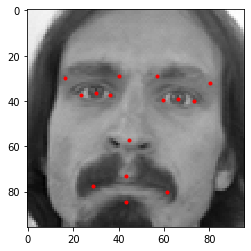

30


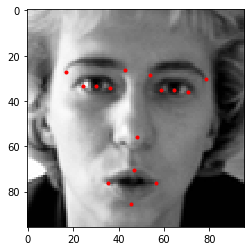

30


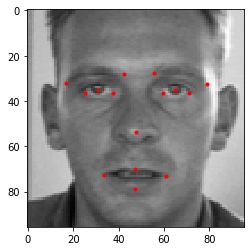

30


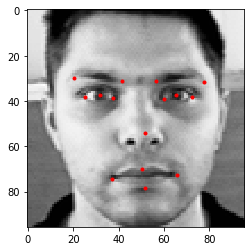

30


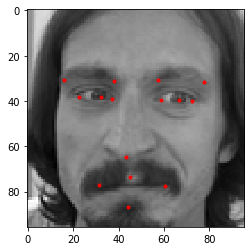

In [11]:
plot_faces(X_train,Y_train)

In [12]:
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

X2_train, Y2_train = preprocess_images(X_train, Y_train, preprocess)

30


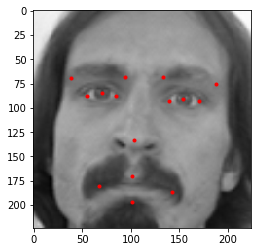

30


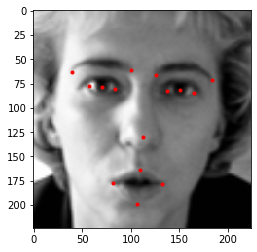

30


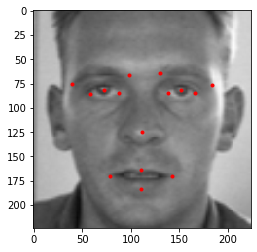

30


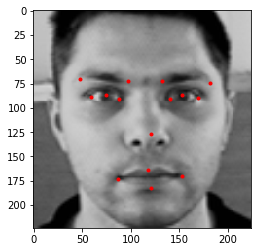

30


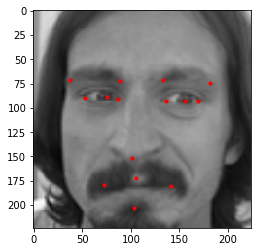

In [13]:
plot_faces([i.transpose(1,2,0) for i in X2_train], Y2_train)

In [14]:
X_final_training = reshape_images_for_resnet(X2_train)
X_final_training.shape

(2140, 3, 224, 224)

In [15]:
import torchvision as tv
import torch.nn as nn

net = tv.models.resnet18(pretrained=True)
net.fc = model = nn.Sequential(
          nn.Linear(512,256),
          nn.ReLU(),
          nn.Linear(256,30)
        )

#Output final architecture
net.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
#Define Loss
loss_function = nn.MSELoss()

def nanmse(ouput, target):
  # print(output.shape, target.shape)
  diff = torch.sub(output, target)
  print(diff)
  sum_squared = torch.pow(diff, 2)
  # print(sum_squared)
  loss = torch.nanmean(sum_squared)
  # print(loss)
  return loss

# loss_function = nanmse
  
#Define Optimizer(SGD)
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

#worker-cores
if sys.platform.startswith('win'):
    num_workers = 0
else:
    num_workers = 2


In [17]:

X_data_augmented = []
Y_data_augmented = []

for k in range(DATASET_AUGMENTATION_FACTOR):
  for i in range(len(X_final_training)):
    img, xy = crop(X_final_training[i],Y2_train[i])

    X_data_augmented.append(img)
    Y_data_augmented.append(xy)

X_data_augmented[0].shape

torch.Size([3, 224, 224])

In [18]:

trainloader, testloader = define_data_loader(X_data_augmented, Y_data_augmented, BATCH_SIZE, 0.15)


In [19]:
X_final_training = None
Y2_train = None
X2_train = None

In [20]:

#Move the input and model to GPU for speed if available
net.to(device)

# Specify the number of epochs for training
#Instatiate Logs
running_loss_history = []
running_corrects_history = []

wandb.init(project="facial-landmark-detection", entity="leo-team", config={"net": "ResNet18, Lin-ReLu-Lin", "optimizer": "Adam", "epochs": EPOCHS, "batch_size": BATCH_SIZE, "lr": LR, "momemtum": MOMENTUM, "weight decay" : WEIGHT_DECAY, "DATASET_AUGMENTATION_FACTOR" : DATASET_AUGMENTATION_FACTOR})
#Train the net
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    running_corrects = 0.0
    net.train()

    for inputs, labels in trainloader:
        
        inputs = inputs.to(device) 
        labels = labels.to(device)

        # forward + backward + optimize
        output = net(inputs)
        
        print("train:", inputs.shape, output.shape, labels.shape)
        loss = loss_function(output,labels)
        running_loss += loss

        # setting initial parameter gradients to 0
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        # print statistics
        #print("loss:",loss.item())
        #running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.

    epoch_loss = running_loss/len(trainloader) # loss per epoch
    #epoch_acc = running_corrects.float()/ len(trainloader) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying
    #running_corrects_history.append(epoch_acc)
    # net.eval()

    net.eval()
    with torch.no_grad():
      test_loss_epoch = 0.0

    
      for X_test, y_test in testloader:
        X_test = X_test.to(device) 
        y_test = y_test.to(device)
        
        output_test = net(X_test)

        print("test:", X_test.shape, output_test.shape, y_test.shape)
        b_l = loss_function(output_test, y_test) 
        test_loss_epoch += b_l
      test_loss_epoch /= len(testloader)  
    print('epoch {}, train loss {}, test loss {}'.format(epoch+1, epoch_loss, test_loss_epoch))

    wandb.log({
      "train_loss": epoch_loss,
      "test_loss": test_loss_epoch,
    })
    

wandb: Currently logged in as: leonardhorns (leo-team). Use `wandb login --relogin` to force relogin


train: torch.Size([400, 3, 224, 224]) torch.Size([400, 30]) torch.Size([400, 30])
train: torch.Size([400, 3, 224, 224]) torch.Size([400, 30]) torch.Size([400, 30])
train: torch.Size([400, 3, 224, 224]) torch.Size([400, 30]) torch.Size([400, 30])
train: torch.Size([400, 3, 224, 224]) torch.Size([400, 30]) torch.Size([400, 30])
train: torch.Size([400, 3, 224, 224]) torch.Size([400, 30]) torch.Size([400, 30])
train: torch.Size([400, 3, 224, 224]) torch.Size([400, 30]) torch.Size([400, 30])
train: torch.Size([400, 3, 224, 224]) torch.Size([400, 30]) torch.Size([400, 30])
train: torch.Size([400, 3, 224, 224]) torch.Size([400, 30]) torch.Size([400, 30])
train: torch.Size([400, 3, 224, 224]) torch.Size([400, 30]) torch.Size([400, 30])
train: torch.Size([38, 3, 224, 224]) torch.Size([38, 30]) torch.Size([38, 30])
test: torch.Size([400, 3, 224, 224]) torch.Size([400, 30]) torch.Size([400, 30])
test: torch.Size([242, 3, 224, 224]) torch.Size([242, 30]) torch.Size([242, 30])
epoch 1, train loss 1

30


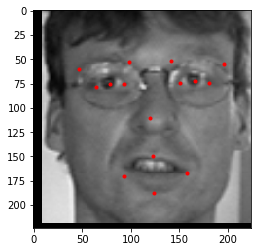

30


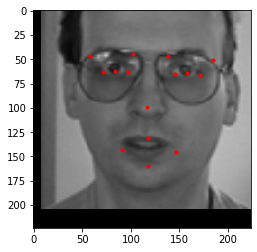

30


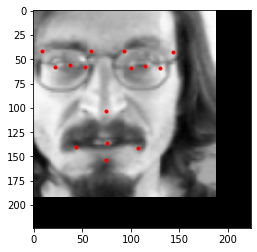

30


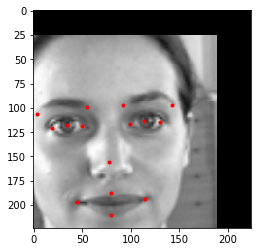

30


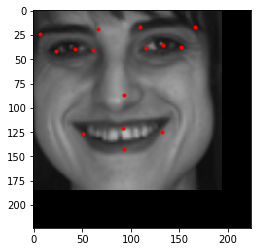

30


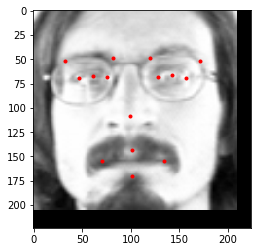

30


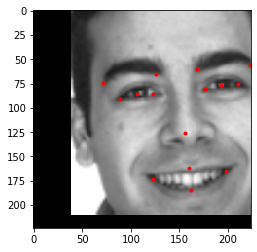

30


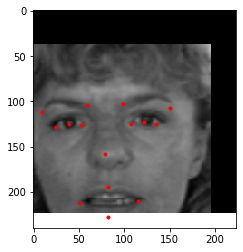

30


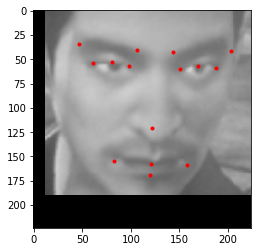

30


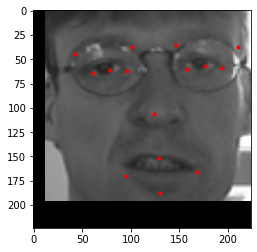

30


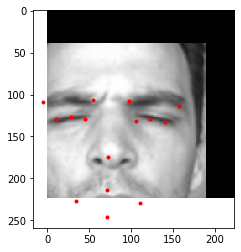

30


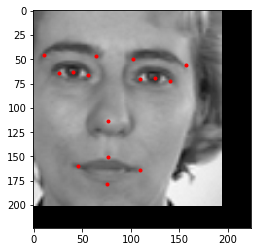

30


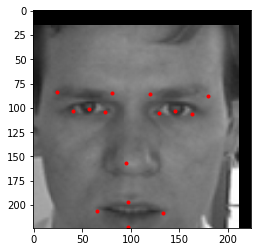

30


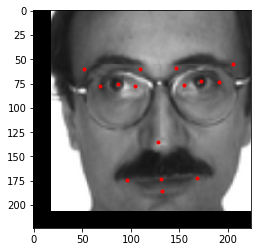

30


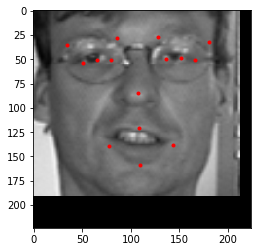

30


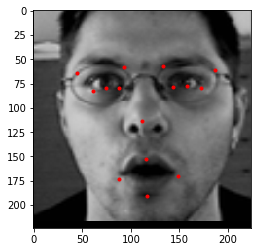

30


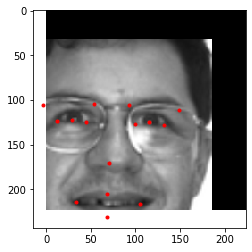

30


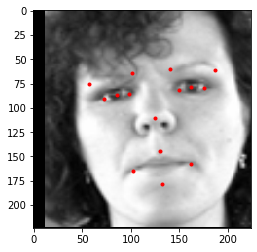

30


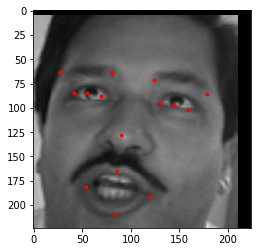

30


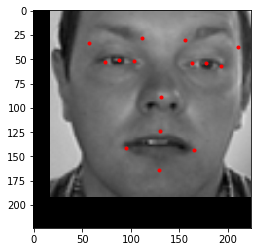

In [28]:
plot_predicated_faces(testloader,20)

30


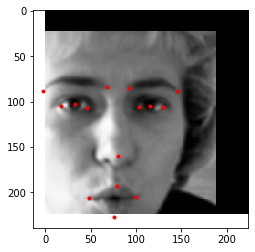

In [22]:
dataiter = iter(testloader)
images, labels = dataiter.next()
coordinates = labels.cpu().detach().numpy()
np_images = images.cpu().detach().numpy()


#plot_face(TF.to_pil_image(np_images[0].transpose(1,2,0)),coordinates[0])
img, xy = crop(np_images[0],coordinates[0])
plot_face(TF.to_pil_image(img),xy)


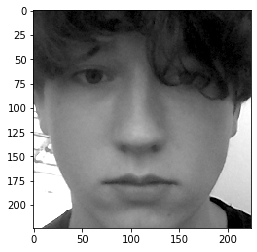

[[220.37999    77.698265   54.755833   72.07039   192.39282    78.83531
  248.75021    85.2821     83.332436   74.563995   28.489674   76.48049
  178.0984     31.992983  279.0726     49.150066   97.41605    29.880575
   -1.3029158  40.8427    131.23143   135.6534    196.1081    241.80435
   69.84637   238.34709   131.25626   203.15924   129.70694   279.13345  ]]
30


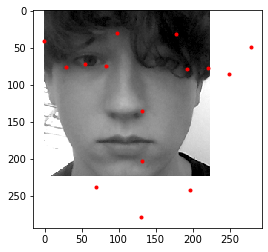

In [27]:
test_image = transforms.Resize(224)(Image.open("/content/test-webcam-leo.png").convert("RGB"))

test_image = np.array(test_image, dtype='uint8')
# print(test_image)

plot_face(TF.to_pil_image(test_image))

test_image2 = np.array([test_image.transpose(2,0,1)])
test_image2.shape

test_image2 = torch.tensor(test_image2, dtype=torch.float32).to(device)
test_image2

labels = net(test_image2)
coordinates = labels.cpu().detach().numpy()
print(coordinates)

plot_face(TF.to_pil_image(test_image), coordinates[0])
# X_data_augmented[0:1]
# data_loader = torch.utils.data.DataLoader(X_data_augmented[0:1], batch_size=1, shuffle=False, num_workers=1)
# for inputs in data_loader:
#   plot_face(TF.to_pil_image)